# 字体数字分类

## 创建随机字体数字图片

In [58]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw 

In [59]:
import torch 

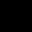

In [60]:
img = np.zeros((32,32,3), dtype=np.uint8)
Image.fromarray(img)

In [61]:

def get_img(text, nums=1, shape=(28,28,3)):
    img = np.random.randint(0, int(255 * 0.92), shape, dtype=np.uint8)
    # img = np.zeros(shape, dtype=np.uint8)
    img = cv2.putText(img, f"{text}", (3, shape[1] - 3), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return img 

Image.fromarray(get_img(8))

In [78]:
# img = get_img(8)
# cv2.imwrite("onnx.jpg", img)


True

## 创建数据

In [62]:
import random 
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader


In [63]:
class FontNumberDataset(Dataset):
    def __init__(self, length=10000):
        self.length = length
    
    def __len__(self):
        return self.length 
    
    def __getitem__(self, idx):
        label = random.randint(0, 9)
        img = get_img(label)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = torch.Tensor(gray)
        # gray = gray.gray = gray.unsqueeze(0)
        return gray, label


In [64]:

train_dataloader = DataLoader(FontNumberDataset(), batch_size=64, shuffle=True)
test_dataloader = DataLoader(FontNumberDataset(), batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 28, 28])
Labels batch shape: torch.Size([64])


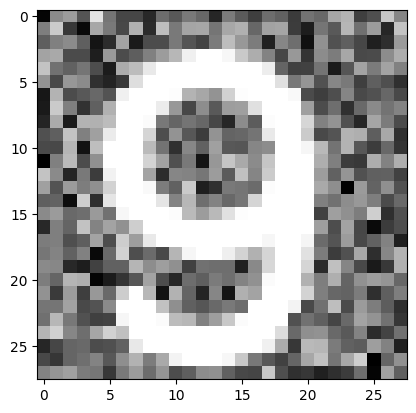

Label: 9


In [65]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 创建PyTorch模型

In [66]:
import torch
from torch import nn
from torchvision.transforms import ToTensor

In [67]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## 创建优化器

In [68]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## 训练模型

In [69]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [70]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [71]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 22.389294  [   64/10000]
loss: 0.014086  [ 6464/10000]
Test Error: Accuracy: 100.0%, Avg loss: 0.008982
Epoch 2
-------------------------------
loss: 0.006140  [   64/10000]
loss: 0.013978  [ 6464/10000]
Test Error: Accuracy: 100.0%, Avg loss: 0.003059
Epoch 3
-------------------------------
loss: 0.002013  [   64/10000]
loss: 0.001480  [ 6464/10000]
Test Error: Accuracy: 100.0%, Avg loss: 0.001866
Epoch 4
-------------------------------
loss: 0.001109  [   64/10000]
loss: 0.002593  [ 6464/10000]
Test Error: Accuracy: 100.0%, Avg loss: 0.001402
Epoch 5
-------------------------------
loss: 0.004573  [   64/10000]
loss: 0.000733  [ 6464/10000]
Test Error: Accuracy: 100.0%, Avg loss: 0.001098
Epoch 6
-------------------------------
loss: 0.000617  [   64/10000]
loss: 0.004546  [ 6464/10000]
Test Error: Accuracy: 100.0%, Avg loss: 0.000944
Epoch 7
-------------------------------
loss: 0.000500  [   64/10000]
loss: 0.001331  [ 6464/10000]
Test 

## 保存模型

## Saving Models

In [72]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

In [73]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## 模型评价

In [74]:
for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    print(X.shape, X.dtype, X.device)
    model.to(device)
    model(X)
    break 

torch.Size([64, 28, 28]) torch.float32 cuda:0


In [75]:
img = get_img(2)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

x = torch.from_numpy(np.array(gray, dtype=np.float32))
x = x.unsqueeze(0).unsqueeze(0)

model.eval()


x = x.to(device)
model = model.to(device)
print(x.shape, x.dtype, x.device)

with torch.no_grad():
    pred = model(x)
    print(pred)
    print(pred.argmax(0))

# with torch.no_grad():
#     pred = model(x)
#     predicted, actual = classes[pred[0].argmax(0)], classes[y]
#     print(f'Predicted: "{predicted}", Actual: "{actual}"')

torch.Size([1, 1, 28, 28]) torch.float32 cuda:0
tensor([[-4.6796, -1.2678, 10.3736, -4.2401, -4.0412,  2.1259, -1.9845, -0.4374,
         -5.7449,  0.3876]], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [76]:
tdata = DataLoader(FontNumberDataset(4), batch_size=4, shuffle=True)

for batch, (X, y) in enumerate(tdata):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    print(pred, y)

    print(pred.argmax(1) == y)


tensor([[-2.5519e+00, -3.1206e+00,  2.3508e+00, -8.4063e-02, -9.9411e+00,
          1.2380e+01, -1.6123e+00, -6.1617e+00, -3.3131e+00, -1.5956e+00],
        [-6.4868e-01, -2.2897e+00, -2.8114e+00,  1.0261e+00, -6.0435e+00,
          1.2950e+01,  8.5946e-01, -9.7436e+00,  2.2286e+00, -4.4550e-01],
        [-3.2189e+00, -2.8422e+00,  1.1369e+01, -4.1885e+00, -6.0343e+00,
          8.5445e-01, -3.0738e+00, -1.8586e+00, -1.8580e+00, -3.2832e+00],
        [-2.6739e-01, -8.3912e-01,  1.5013e-03, -7.6809e+00, -6.3550e+00,
          2.8927e+00, -2.8425e+00, -4.3825e+00, -3.4990e+00,  1.0039e+01]],
       device='cuda:0', grad_fn=<AddmmBackward0>) tensor([5, 5, 2, 9], device='cuda:0')
tensor([True, True, True, True], device='cuda:0')
